## Skipgrams in Keras

- In this lecture, we will implement Skipgrams in `Keras`.

#### Loading in and preprocessing data
- Load the Alice in Wonderland data in Corpus using Keras utility
- `Keras` has some nice text preprocessing features too!
- Split the text into sentences.
- Use `Keras`' `Tokenizer` to tokenize sentences into words.

In [44]:
# Imports
# Basics
from __future__ import print_function, division
import pandas as pd 
import numpy as np
import random
from IPython.display import SVG
%matplotlib inline

# nltk
from nltk import sent_tokenize

# keras
np.random.seed(13)
from keras.models import Sequential
from keras.layers import Input, Dense, Embedding, Reshape, Activation
from keras.layers import add
from keras.models import Model

from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot 
from keras.preprocessing.sequence import skipgrams

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/olszewskip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# We'll use Alice in Wonderland

path = get_file('carrol-alice.txt', origin="http://www.gutenberg.org/files/11/11-0.txt")
corpus = open(path).read()

In [4]:
len(corpus)

163817

In [5]:
corpus[: corpus.index('\n\n')+2]

'\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll\n\n'

In [6]:
start = corpus.index("CHAPTER I")
corpus[start:start+100]

'CHAPTER I. Down the Rabbit-Hole\n\nAlice was beginning to get very tired of sitting by her sister on t'

In [7]:
# Split document into sentences first
corpus = corpus[start:]  # remove header.
sentences = sent_tokenize(corpus)

In [8]:
sentences[:5]

['CHAPTER I.',
 'Down the Rabbit-Hole\n\nAlice was beginning to get very tired of sitting by her sister on the\nbank, and of having nothing to do: once or twice she had peeped into the\nbook her sister was reading, but it had no pictures or conversations in\nit, ‘and what is the use of a book,’ thought Alice ‘without pictures or\nconversations?’\n\nSo she was considering in her own mind (as well as she could, for the\nhot day made her feel very sleepy and stupid), whether the pleasure\nof making a daisy-chain would be worth the trouble of getting up and\npicking the daisies, when suddenly a White Rabbit with pink eyes ran\nclose by her.',
 'There was nothing so VERY remarkable in that; nor did Alice think it so\nVERY much out of the way to hear the Rabbit say to itself, ‘Oh dear!',
 'Oh dear!',
 'I shall be late!’ (when she thought it over afterwards, it\noccurred to her that she ought to have wondered at this, but at the time\nit all seemed quite natural); but when the Rabbit actually

In [9]:
# Tokenize using Keras
base_filter='!"#$%&()*+,-./:;`<=>?@[\\]^_{|}~\t\n' + "'"
tokenizer = Tokenizer(filters=base_filter)
tokenizer.fit_on_texts(sentences)
# Convert tokenized sentences to sequence format
sequences = tokenizer.texts_to_sequences(sentences)

In [10]:
sequences[:2]

[[343, 15],
 [37,
  1,
  109,
  704,
  12,
  13,
  275,
  4,
  116,
  29,
  550,
  6,
  405,
  59,
  17,
  481,
  20,
  1,
  1005,
  3,
  6,
  406,
  152,
  4,
  44,
  148,
  27,
  705,
  7,
  22,
  1006,
  68,
  1,
  373,
  17,
  481,
  13,
  819,
  30,
  8,
  22,
  47,
  820,
  27,
  1300,
  10,
  8,
  79,
  41,
  31,
  1,
  161,
  6,
  5,
  373,
  2,
  62,
  12,
  1829,
  820,
  27,
  1300,
  2,
  28,
  7,
  13,
  1007,
  10,
  17,
  407,
  374,
  16,
  121,
  16,
  7,
  57,
  24,
  1,
  551,
  162,
  153,
  17,
  482,
  29,
  706,
  3,
  1008,
  375,
  1,
  1301,
  6,
  483,
  5,
  1830,
  1831,
  58,
  25,
  821,
  1,
  624,
  6,
  203,
  39,
  3,
  1302,
  1,
  1832,
  60,
  314,
  5,
  154,
  109,
  18,
  1833,
  163,
  258,
  315,
  59,
  17]]

In [11]:
# nb_samples = sum(len(s) for s in corpus)  # whats that for?

print(len(sequences), tokenizer.document_count)

1092 1092


In [12]:
# To understand what is happening;

print(sentences[323])  # this is a sentence
print(sequences[323])  # this is the same sentence where words are encoded as numbers.
print(list(tokenizer.word_index[word.lower().replace('.', '')] for word in sentences[323].split()))

The Caterpillar was the first to speak.
[1, 181, 13, 1, 98, 4, 328]
[1, 181, 13, 1, 98, 4, 328]


#### Skipgrams: Generating Input and Output Labels
- Now that we have sentences, and word tokenization, we are in good position to create our training set for skipgrams.
- Now we need to generate our `X_train` and `y_train`

In [13]:
# Let's first see how Keras' skipgrams function works.

couples, labels = skipgrams(sequences[323], len(tokenizer.word_index) + 1,
    window_size=2, negative_samples=0, shuffle=True,
    categorical=False, sampling_table=None)

In [14]:
sequences[323]

[1, 181, 13, 1, 98, 4, 328]

In [15]:
couples

[[98, 13],
 [328, 4],
 [181, 1],
 [4, 98],
 [1, 4],
 [1, 13],
 [13, 98],
 [1, 181],
 [181, 13],
 [13, 1],
 [1, 98],
 [1, 181],
 [98, 4],
 [181, 1],
 [328, 98],
 [98, 1],
 [4, 328],
 [98, 328],
 [13, 1],
 [4, 1],
 [13, 181],
 [1, 13]]

In [16]:
list(tokenizer.word_index.items())[:10]

[('the', 1),
 ('’', 2),
 ('and', 3),
 ('to', 4),
 ('a', 5),
 ('of', 6),
 ('she', 7),
 ('it', 8),
 ('said', 9),
 ('in', 10)]

In [17]:
index_2_word = {val: key for key, val in tokenizer.word_index.items()}

In [18]:
for w1, w2 in couples:
    print(index_2_word[w1], index_2_word[w2])

first was
speak to
caterpillar the
to first
the to
the was
was first
the caterpillar
caterpillar was
was the
the first
the caterpillar
first to
caterpillar the
speak first
first the
to speak
first speak
was the
to the
was caterpillar
the was


In [19]:
# Function to generate the inputs and outputs for all windows

# Vocab size
vocab_size = len(tokenizer.word_index) + 1
# Dimension to reduce to
dim = 100
window_size = 2


def generate_data(sequences, window_size, vocab_size):
    for seq in sequences:
        X, y = [], []
        couples, _ = skipgrams(
            seq, vocab_size,
            window_size=window_size, negative_samples=0, shuffle=True,
            categorical=False, sampling_table=None)
        if not couples:
            continue
        for in_word, out_word in couples:
            X.append(in_word)
            y.append(np_utils.to_categorical(out_word, vocab_size))
        X, y = np.array(X), np.array(y)
        X = X.reshape(len(X), 1)
        y = y.reshape(len(X), vocab_size)
        yield X, y
        
data_generator = generate_data(sequences, window_size, vocab_size)

### Skipgrams: Creating the Model
- Lastly, we create the (shallow) network!

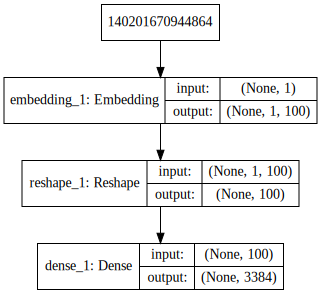

In [20]:
# Create the Keras model and view it 
skipgram = Sequential()
skipgram.add(Embedding(input_dim=vocab_size, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim,)))
skipgram.add(Dense(input_dim=dim, units=vocab_size, activation='softmax'))
SVG(model_to_dot(skipgram, show_shapes=True).create(prog='dot', format='svg'))

### Skipgrams: Compiling and Training
- Time to compile and train
- We use crossentropy, common loss for classification

In [143]:
# Compile the Keras Model
#from keras.optimizers import SGD
#sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9)

skipgram.compile(loss='categorical_crossentropy', optimizer="adadelta")

# Fit the Skipgrams
for iteration in range(10):
    loss = 0
    for x, y in generate_data(sequences, window_size, vocab_size):
        loss += skipgram.train_on_batch(x, y)
    print('iteration {}, loss is {}'.format(iteration, loss))

iteration 0, loss is 6712.05944609642
iteration 1, loss is 6683.798287391663
iteration 2, loss is 6651.352287054062
iteration 3, loss is 6619.84747672081
iteration 4, loss is 6590.538501739502
iteration 5, loss is 6564.116360425949
iteration 6, loss is 6540.191687345505
iteration 7, loss is 6518.1522924900055
iteration 8, loss is 6497.632173061371
iteration 9, loss is 6478.38989841938


### Skipgrams: Looking at the vectors

To get word_vectors now, we look at the weights of the first layer.

Let's also write functions giving us similarity of two words.

In [144]:
word_vectors = skipgram.get_weights()[0]


from scipy.spatial.distance import cosine


def get_dist(w1, w2):
    i1, i2 = tokenizer.word_index[w1], tokenizer.word_index[w2]
    v1, v2 = word_vectors[i1], word_vectors[i2]
    return cosine(v1, v2)

def get_similarity(w1, w2):
    return 1-get_dist(w1, w2)

def get_most_similar(w1, n=10):
    sims = {word: get_similarity(w1, word) 
            for word in tokenizer.word_index.keys()
            if word != w1}
    sims = pd.Series(sims)
    sims.sort_values(inplace=True, ascending=False)
    return sims.iloc[:n]


print(get_similarity('king', 'queen'))
print('')
print(get_most_similar('queen'))

0.9441558718681335

gryphon        0.954021
duchess        0.946990
king           0.944156
hatter         0.940838
dormouse       0.933425
caterpillar    0.922985
footman        0.919527
cat            0.914474
march          0.908806
mouse          0.904107
dtype: float64


## Your turn -- Modify the code above to create a CBOW Model

In [145]:
def generate_data_cbow(sequences, window_size, vocab_size):
    
    for seq in sequences:
        
        if not seq:
            continue
        #assert(len(seq) > 0)  
        
        X = np.zeros((len(seq), 2 * window_size), 'int')
        y = np.zeros((len(seq), vocab_size), 'int')
        #print(seq, ':')
        
        for token_index, token in enumerate(seq):
            y[token_index] = np_utils.to_categorical(token, vocab_size)
            neighbors = seq[max(0, token_index - window_size) : token_index] +\
                        seq[min(len(seq)-1, token_index) + 1: token_index + 1 + window_size]
            #print(token_index, token, neighbors)
            #assert(len(neighbors) <= 2 * window_size)
            for neighbor_index, neighbor in enumerate(neighbors):
                X[token_index, neighbor_index] = neighbor
            #print(X[token_index])

        yield X, y
        
data_generator = generate_data_cbow(sequences, window_size, vocab_size)

In [146]:
inputs = [Input(shape=(1,), dtype='int32', name=f'neigbor_{n}') for n in range(2 * window_size)]

In [147]:
the_embedding = Embedding(input_dim=vocab_size,\
                          output_dim=dim,\
                          embeddings_initializer='glorot_uniform',\
                          input_length=1,
                          name='embedding')
embedded_inputs = [the_embedding(input_) for input_ in inputs]

In [148]:
cbow = Reshape((dim,))(add(embedded_inputs))
prediction = Dense(vocab_size, activation='softmax', name='predict_sparse_token')(cbow)

In [149]:
cbow_model = Model(inputs=inputs, outputs=[prediction])

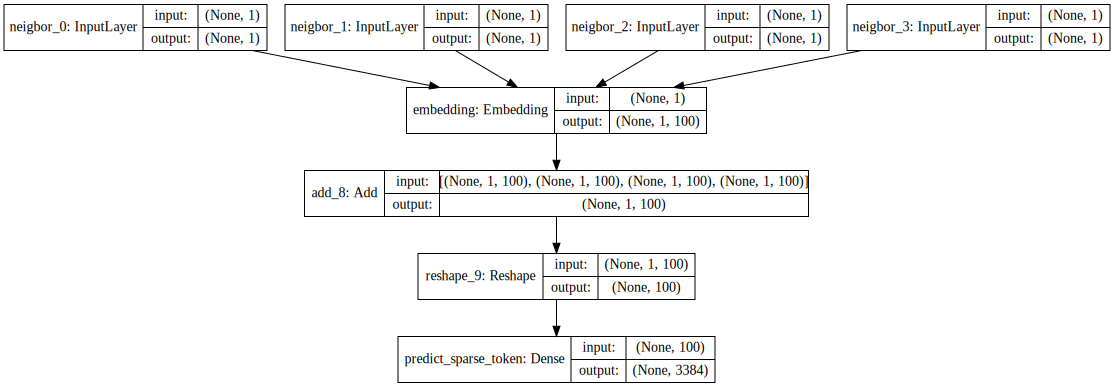

In [150]:
SVG(model_to_dot(cbow_model, show_shapes=True).create(prog='dot', format='svg'))

In [151]:
cbow_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
neigbor_0 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
neigbor_1 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
neigbor_2 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
neigbor_3 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
embedding 

In [155]:
cbow_model.compile(loss='categorical_crossentropy', optimizer="adadelta")

for iteration in range(10):
    loss = 0
    for X, y in generate_data_cbow(sequences, window_size, vocab_size):
        loss += cbow_model.train_on_batch([X[:, idx] for idx in range(2 * window_size)], y)
    print('iteration {}, loss is {}'.format(iteration, loss))

iteration 0, loss is 7143.60152721405
iteration 1, loss is 6874.8231472969055
iteration 2, loss is 6691.971711874008
iteration 3, loss is 6540.220075368881
iteration 4, loss is 6411.5310690402985
iteration 5, loss is 6301.271844148636
iteration 6, loss is 6205.562391996384
iteration 7, loss is 6119.319103002548
iteration 8, loss is 6039.4762444496155
iteration 9, loss is 5965.435489177704


In [160]:
word_vectors = cbow_model.get_layer('embedding').get_weights()[0]
word_vectors.shape

(3384, 100)

In [161]:
word_vectors = cbow_model.get_layer('embedding').get_weights()[0]

from scipy.spatial.distance import cosine


def get_dist(w1, w2):
    i1, i2 = tokenizer.word_index[w1], tokenizer.word_index[w2]
    v1, v2 = word_vectors[i1], word_vectors[i2]
    return cosine(v1, v2)

def get_similarity(w1, w2):
    return 1-get_dist(w1, w2)

def get_most_similar(w1, n=10):
    sims = {word: get_similarity(w1, word) 
            for word in tokenizer.word_index.keys()
            if word != w1}
    sims = pd.Series(sims)
    sims.sort_values(inplace=True, ascending=False)
    return sims.iloc[:n]


print(get_similarity('king', 'queen'))
print('')
print(get_most_similar('queen'))

0.8831360936164856

gryphon        0.913168
hatter         0.898623
footman        0.895087
caterpillar    0.893760
dormouse       0.890391
king           0.883136
duchess        0.882594
soldiers       0.880809
door           0.869426
table          0.861104
dtype: float64
